# Synthetic PeMS-like Spatio-Temporal Dataset Generator (Publication-Ready)

This notebook generates **PeMS-structured synthetic traffic data** to test model robustness under a controlled
data-generating process (DGP) that includes:

- **Temporal dynamics** (autoregression)
- **Diurnal + weekly seasonality**
- **Graph-based spatial propagation** (using the *same* adjacency structure as PeMS when available)
- **Heteroskedastic noise** (higher variance during rush hours)
- **Incidents / shocks**, **regime shifts**, and **missingness/outages**
- **Leakage-safe imputation** (train-only statistics)

## Output artifact 

For each scenario and random seed, this notebook writes a strict `.npz` dataset with the **same keys and tensor
shapes** used by your model notebooks:

- `X`: `(T, N, 6)`  → `[flow, speed, hour_sin, hour_cos, dow_sin, dow_cos]`
- `Y`: `(T, N)`     → flow target
- `A`: `(N, N)`     → adjacency
- `train_starts`, `val_starts`, `test_starts` → strict, leakage-free window splits
- `in_len=24`, `out_len=72` (same as PeMS)
- per-node scalers computed using **train period only**

After generating these artifacts, we can run **GraphWaveNet / STGCN / other baselines** by pointing their
`DATASET_NPZ_STRICT` path to one of the generated files.

---

## 1) Reproducibility and configuration

In [2]:
!pip -q install numpy pandas matplotlib scipy torch tqdm

import os
import json
import math
import random
from pathlib import Path
from dataclasses import dataclass, asdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse


In [3]:
# Reproducibility (matches the style used in your PeMS notebooks)

def set_seed(seed: int = 42, deterministic: bool = True):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        if deterministic:
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
    except Exception:
        # torch not required for dataset generation
        pass

set_seed(42)

In [4]:
ROOT = Path(".").resolve()  # notebook working directory
OUT_ROOT = Path("synthetic_pems_output").resolve()
ARTIFACTS_DIR = OUT_ROOT / "artifacts"
CONFIGS_DIR   = OUT_ROOT / "configs"
FIGURES_DIR   = OUT_ROOT / "figures"

for p in [OUT_ROOT, ARTIFACTS_DIR, CONFIGS_DIR, FIGURES_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Output root:", OUT_ROOT)

Output root: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/synthetic_pems_output


## 2) Load the PeMS graph adjacency (preferred) or create a realistic fallback

We reuse your PeMS adjacency `A` and station list from the strict artifact  
`artifacts/pems_graph_dataset_strict.npz`. This guarantees the synthetic data has the **same graph structure**
as the real dataset.

In [5]:
def find_upwards(relative_path: str, start: Path = Path("."), max_levels: int = 6) -> Path | None:
    cur = start.resolve()
    for _ in range(max_levels + 1):
        candidate = cur / relative_path
        if candidate.exists():
            return candidate
        if cur.parent == cur:
            break
        cur = cur.parent
    return None

PEMS_STRICT = find_upwards("artifacts/pems_graph_dataset_strict.npz", start=Path("."), max_levels=8)
PEMS_BASE   = find_upwards("artifacts/pems_graph_dataset.npz", start=Path("."), max_levels=8)

print("Found PeMS strict:", PEMS_STRICT)
print("Found PeMS base:  ", PEMS_BASE)

Found PeMS strict: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/pems_graph_dataset_strict.npz
Found PeMS base:   /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/artifacts/pems_graph_dataset.npz


In [6]:
# Try to load adjacency and (optionally) per-node train scalers from PeMS.
A = None
stations = None
target_flow_mean = None
target_flow_std  = None
target_speed_mean = None
target_speed_std  = None

if PEMS_STRICT is not None:
    d = np.load(PEMS_STRICT, allow_pickle=True)
    A = d["A"].astype(np.float32)
    stations = d["stations"].astype(np.int32)

    # Train-only scalers computed in your PeMS pipeline.
    # We use them optionally to calibrate synthetic ranges (moment-matching).
    if "flow_mean" in d and "flow_std" in d:
        target_flow_mean = d["flow_mean"].astype(np.float32)
        target_flow_std  = d["flow_std"].astype(np.float32)
    if "speed_mean" in d and "speed_std" in d:
        target_speed_mean = d["speed_mean"].astype(np.float32)
        target_speed_std  = d["speed_std"].astype(np.float32)

elif PEMS_BASE is not None:
    d = np.load(PEMS_BASE, allow_pickle=True)
    A = d["A"].astype(np.float32)
    stations = d["stations"].astype(np.int32)
    if "flow_mean" in d and "flow_std" in d:
        target_flow_mean = d["flow_mean"].astype(np.float32)
        target_flow_std  = d["flow_std"].astype(np.float32)
    if "speed_mean" in d and "speed_std" in d:
        target_speed_mean = d["speed_mean"].astype(np.float32)
        target_speed_std  = d["speed_std"].astype(np.float32)

if A is not None:
    print("Loaded PeMS adjacency A:", A.shape, "stations:", stations.shape)
else:
    print(" PeMS artifact not found. Will build a fallback synthetic graph.")

Loaded PeMS adjacency A: (1821, 1821) stations: (1821,)


In [7]:
def build_knn_graph(N: int, k: int = 4, seed: int = 0, sigma: float | None = None) -> np.ndarray:
    '''
    Fallback road-like graph:
      - sample 2D coordinates
      - connect k-nearest neighbors
      - weight edges with Gaussian kernel
    '''
    rng = np.random.default_rng(seed)
    xy = rng.uniform(0, 1, size=(N, 2)).astype(np.float32)

    # pairwise distances
    diff = xy[:, None, :] - xy[None, :, :]
    dist = np.sqrt((diff**2).sum(axis=2) + 1e-9)

    # kNN (excluding self)
    idx = np.argsort(dist, axis=1)[:, 1:k+1]
    A = np.zeros((N, N), dtype=np.float32)
    knn_dists = []
    for i in range(N):
        for j in idx[i]:
            A[i, j] = dist[i, j]
            A[j, i] = dist[i, j]
            knn_dists.append(dist[i, j])

    knn_dists = np.array(knn_dists, dtype=np.float32)
    if sigma is None:
        sigma = float(np.median(knn_dists) + 1e-6)

    # convert distances to weights
    W = np.exp(-(A**2) / (sigma**2)).astype(np.float32)
    np.fill_diagonal(W, 1.0)
    return W

if A is None:
    N_fallback = 325  # reasonable default (can adjust)
    A = build_knn_graph(N_fallback, k=4, seed=42)
    stations = np.arange(N_fallback, dtype=np.int32)

print("Using A:", A.shape, "stations:", stations.shape)

Using A: (1821, 1821) stations: (1821,)


## 3) Match PeMS tensor conventions (IN_LEN, OUT_LEN, strict splits)

We keep the same forecasting setup used in your PeMS experiments:

- `IN_LEN = 24` hours history
- `OUT_LEN = 72` hours prediction window
- evaluate at horizons `[12, 24, 48, 72]`

We also keep the same *date-based* split boundaries:

- Train: output windows end on or before **2024-11-15**
- Val:   windows start after 2024-11-15 and end on/before **2024-11-30**
- Test:  windows start after 2024-11-30

This is the strict split rule that prevents any label leakage.

In [8]:
# Forecast setup (match PeMS notebooks)
IN_LEN  = 24
OUT_LEN = 72
EVAL_HORIZONS = [12, 24, 48, 72]

# Split boundaries (match PeMS notebooks)
TRAIN_END = pd.Timestamp("2024-11-15 23:59:59")
VAL_END   = pd.Timestamp("2024-11-30 23:59:59")

# Generate timestamps that cover train/val/test (hourly)
START_DATE = "2024-09-01 00:00:00"
END_DATE   = "2024-12-31 23:00:00"
timestamps = pd.date_range(START_DATE, END_DATE, freq="H")

print("Timestamps:", timestamps[0], "→", timestamps[-1], " (T=", len(timestamps), ")")
assert timestamps[0] < TRAIN_END < VAL_END < timestamps[-1]

Timestamps: 2024-09-01 00:00:00 → 2024-12-31 23:00:00  (T= 2928 )


/tmp/ipykernel_42/10119280.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(START_DATE, END_DATE, freq="H")


## 4) Synthetic DGP: spatio-temporal traffic dynamics (PeMS-like)

We simulate a latent traffic state $z_t \in \mathbb{R}^N$:

$$
z_t = \sum_{k=1}^{K}\phi_k z_{t-k} + \sum_{k=0}^{K_s}\psi_k \hat{A} z_{t-k} + s(t) + u_t + \epsilon_t
$$

Where:

- $\hat{A}$ is a normalized adjacency (graph propagation)
- $s(t)$ contains **daily (24h)** and **weekly (168h)** seasonality
- $u_t$ are sparse incident shocks
- $\epsilon_t$ is heteroskedastic noise (larger during rush hours)

We then map $z_t$ to **flow** (positive) and **speed** (inversely related to flow), and inject missingness/outages.

In [9]:
def normalize_adj(A: np.ndarray):
    '''
    Symmetric normalization: D^{-1/2}(A+I)D^{-1/2}.

    Returns a dense numpy array for dense graphs, or a CSR sparse matrix for sparse graphs.
    '''
    A = A.astype(np.float32)
    N = A.shape[0]

    # add self-loops
    A_sl = A.copy()
    np.fill_diagonal(A_sl, A_sl.diagonal() + 1.0)

    d = A_sl.sum(axis=1)
    d_inv_sqrt = np.power(d, -0.5, where=d > 0).astype(np.float32)

    density = float(np.count_nonzero(A_sl)) / float(N * N)

    if density < 0.05:
        # sparse acceleration (typical for road graphs)
        A_sp = sparse.csr_matrix(A_sl)
        D_sp = sparse.diags(d_inv_sqrt)
        return (D_sp @ A_sp @ D_sp).tocsr()
    else:
        D = np.diag(d_inv_sqrt)
        return (D @ A_sl @ D).astype(np.float32)

def make_seasonality(timestamps: pd.DatetimeIndex,
                     alpha=(1.2, 0.8),
                     beta=(0.6, 0.4)) -> np.ndarray:
    '''Return (T,) daily + weekly seasonality.'''
    t = np.arange(len(timestamps), dtype=np.float32)
    s_daily  = alpha[0]*np.sin(2*np.pi*t/24.0)  + alpha[1]*np.cos(2*np.pi*t/24.0)
    s_weekly = beta[0]*np.sin(2*np.pi*t/168.0) + beta[1]*np.cos(2*np.pi*t/168.0)
    return (s_daily + s_weekly).astype(np.float32)

def match_moments(arr: np.ndarray, target_mean: np.ndarray, target_std: np.ndarray, eps: float = 1e-6):
    '''
    Match per-node mean/std: arr is (T,N), target_* is (N,).
    '''
    mu = np.nanmean(arr, axis=0)
    sd = np.nanstd(arr, axis=0) + eps
    out = (arr - mu[None, :]) / sd[None, :] * target_std[None, :] + target_mean[None, :]
    return out

def simulate_pems_like_flow_speed(
    timestamps: pd.DatetimeIndex,
    A: np.ndarray,
    K: int = 3,
    Ks: int = 1,
    phi=(0.55, 0.20, 0.10),
    psi=(0.18, 0.08),
    p_incident: float = 0.01,
    incident_scale: float = 2.0,
    sigma0: float = 0.30,
    sigma1: float = 0.35,
    rush_hours=(7, 8, 9, 16, 17, 18),
    node_scale_lognorm=(0.0, 0.35),
    regime_shift_at: int | None = None,
    regime_scale: float = 1.25,
    base_speed: float = 65.0,
    seed: int = 0,
):
    '''
    Returns:
      flow_df, speed_df as (T,N) DataFrames with DatetimeIndex.
    '''
    rng = np.random.default_rng(seed)
    T = len(timestamps)
    N = A.shape[0]
    Ahat = normalize_adj(A)

    # Node heterogeneity
    mu, sig = node_scale_lognorm
    c = rng.lognormal(mean=mu, sigma=sig, size=N).astype(np.float32)  # (N,)

    # Seasonality (shared + mild node variation)
    s = make_seasonality(timestamps)  # (T,)
    s_node = (s[:, None] * (0.9 + 0.2*rng.random((1, N))).astype(np.float32)).astype(np.float32)

    # Heteroskedastic noise (rush hour)
    hours = timestamps.hour.values
    rush = np.isin(hours, np.array(rush_hours))
    sig_t = (sigma0 + sigma1 * rush.astype(np.float32)).astype(np.float32)  # (T,)

    # Incidents (sparse shocks)
    incident_mask = (rng.random((T, 1)) < p_incident).astype(np.float32)
    u = incident_mask * rng.normal(0, incident_scale, size=(T, N)).astype(np.float32)

    # Optional regime shift
    if regime_shift_at is not None:
        regime = np.ones((T, 1), dtype=np.float32)
        regime[regime_shift_at:] *= float(regime_scale)
    else:
        regime = np.ones((T, 1), dtype=np.float32)

    # Latent state
    z = np.zeros((T, N), dtype=np.float32)
    z[:K, :] = rng.normal(0, 0.5, size=(K, N)).astype(np.float32)

    # Simulate forward
    for t in range(K, T):
        ar = np.zeros((N,), dtype=np.float32)
        for k in range(1, K+1):
            ar += float(phi[k-1]) * z[t-k]

        sp = float(psi[0]) * (Ahat @ z[t-1])
        if Ks >= 1 and len(psi) > 1:
            sp += float(psi[1]) * (Ahat @ z[t-2])

        eps = rng.normal(0, sig_t[t], size=(N,)).astype(np.float32)
        z[t] = regime[t] * (ar + sp + s_node[t] + u[t] + eps)

    # Map to observed FLOW (positive)
    flow = np.log1p(np.exp(c[None, :] * z)).astype(np.float32)

    # Map to SPEED (inverse relation to flow + noise), clip to realistic range
    speed = base_speed - 10.0*np.tanh(flow) + rng.normal(0, 2.0, size=(T, N)).astype(np.float32)
    speed = np.clip(speed, 5.0, 85.0).astype(np.float32)

    cols = [f"s{i}" for i in range(N)]
    flow_df = pd.DataFrame(flow, index=timestamps, columns=cols)
    speed_df = pd.DataFrame(speed, index=timestamps, columns=cols)
    return flow_df, speed_df

## 5) Missingness + leakage-safe imputation (train-only statistics)

We inject missingness as:
- **point drops** (random missing values)
- **block outages** (contiguous missing segments per sensor)

Then we apply a leakage-safe imputation:
1) forward fill (`ffill`) across time (streaming-realistic)
2) fill remaining NaNs using **per-node TRAIN mean only**
3) fill any remaining NaNs using a **global TRAIN mean only**

This guarantees **no validation/test leakage** in the imputation values.

In [10]:
def inject_missingness(X: np.ndarray,
                       p_point: float = 0.01,
                       p_block: float = 0.002,
                       block_len: tuple[int, int] = (6, 24),
                       seed: int = 0) -> np.ndarray:
    '''
    X: (T,N) array. Returns X with NaNs.
    '''
    rng = np.random.default_rng(seed)
    T, N = X.shape
    Xmiss = X.copy()

    # point drops
    mask_point = rng.random((T, N)) < p_point
    Xmiss[mask_point] = np.nan

    # block outages (per node)
    for n in range(N):
        if rng.random() < p_block:
            start = int(rng.integers(0, max(1, T-1)))
            L = int(rng.integers(block_len[0], block_len[1] + 1))
            end = min(T, start + L)
            Xmiss[start:end, n] = np.nan

    return Xmiss

def leakage_safe_impute(df: pd.DataFrame, train_end: pd.Timestamp) -> pd.DataFrame:
    '''
    Leakage-safe imputation:
      - forward-fill
      - fill remaining NaNs with per-node train mean
      - fill any remaining with global train mean
    '''
    out = df.copy()
    out = out.ffill()  # uses only past values

    train_slice = out.loc[out.index <= train_end]
    per_node_mean = train_slice.mean(axis=0, skipna=True)
    global_mean = float(train_slice.stack().mean(skipna=True))

    out = out.fillna(per_node_mean)
    out = out.fillna(global_mean)

    # sanity
    if out.isna().any().any():
        raise ValueError("Imputation failed: NaNs remain.")
    return out

## 6) Build X and Y tensors (exact PeMS convention)

We reproduce your PeMS feature tensor:

- `flow` channel
- `speed` channel
- time encodings: `hour_sin, hour_cos, dow_sin, dow_cos`

So `X.shape = (T, N, 6)` and target `Y.shape = (T, N)` (flow).

In [11]:
def make_time_features(timestamps: pd.DatetimeIndex) -> np.ndarray:
    hours = timestamps.hour.values
    dow   = timestamps.dayofweek.values
    hour_sin = np.sin(2*np.pi*hours/24.0)
    hour_cos = np.cos(2*np.pi*hours/24.0)
    dow_sin  = np.sin(2*np.pi*dow/7.0)
    dow_cos  = np.cos(2*np.pi*dow/7.0)
    return np.stack([hour_sin, hour_cos, dow_sin, dow_cos], axis=1).astype(np.float32)  # (T,4)

def build_XY(flow_imp: pd.DataFrame, speed_imp: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    assert flow_imp.shape == speed_imp.shape
    T, N = flow_imp.shape

    time_feats = make_time_features(flow_imp.index)  # (T,4)
    time_feats_b = np.repeat(time_feats[:, None, :], repeats=N, axis=1)  # (T,N,4)

    flow_arr  = flow_imp.to_numpy(dtype=np.float32)[:, :, None]   # (T,N,1)
    speed_arr = speed_imp.to_numpy(dtype=np.float32)[:, :, None]  # (T,N,1)

    X = np.concatenate([flow_arr, speed_arr, time_feats_b], axis=2).astype(np.float32)  # (T,N,6)
    Y = flow_arr.squeeze(-1).astype(np.float32)  # (T,N)
    return X, Y

## 7) Strict window starts (no label leakage)

A window starting at time index `t` uses:

- Input:  `X[t : t+IN_LEN]`
- Output: `Y[t+IN_LEN : t+IN_LEN+OUT_LEN]`

**Strict splits**:
- Train if `output_end_time <= TRAIN_END`
- Val if `output_start_time > TRAIN_END` and `output_end_time <= VAL_END`
- Test if `output_start_time > VAL_END`

In [12]:
def make_strict_starts(timestamps: pd.DatetimeIndex, in_len: int, out_len: int,
                       train_end: pd.Timestamp, val_end: pd.Timestamp):
    T_total = len(timestamps)
    max_t = T_total - (in_len + out_len) + 1
    starts = np.arange(max_t, dtype=np.int32)

    out_start_times = timestamps[starts + in_len]
    out_end_times   = timestamps[starts + in_len + out_len - 1]

    train_starts = starts[out_end_times <= train_end]
    val_starts   = starts[(out_start_times > train_end) & (out_end_times <= val_end)]
    test_starts  = starts[out_start_times > val_end]
    return train_starts, val_starts, test_starts

## 8) Define synthetic scenarios (stress tests)

We generate five scenarios:

A. **Nominal** PeMS-like dynamics  
B. **Stronger spatial propagation** (higher graph diffusion)  
C. **Weaker spatial signal**  
D. **Regime shift + more incidents**  
E. **High missingness/outages**

Each scenario can be repeated for multiple random seeds.

In [13]:
SCENARIOS = {
    # name : DGP parameters + missingness parameters
    "A_nominal": dict(
        dgp=dict(phi=(0.55,0.20,0.10), psi=(0.18,0.08), p_incident=0.01, regime_shift_at=None),
        miss=dict(p_point=0.01, p_block=0.002)
    ),
    "B_strong_spatial": dict(
        dgp=dict(phi=(0.55,0.20,0.10), psi=(0.30,0.15), p_incident=0.01, regime_shift_at=None),
        miss=dict(p_point=0.01, p_block=0.002)
    ),
    "C_weak_spatial": dict(
        dgp=dict(phi=(0.55,0.20,0.10), psi=(0.06,0.02), p_incident=0.01, regime_shift_at=None),
        miss=dict(p_point=0.01, p_block=0.002)
    ),
    "D_regime_incidents": dict(
        dgp=dict(phi=(0.55,0.20,0.10), psi=(0.18,0.08), p_incident=0.02,
                 regime_shift_at=int(len(timestamps)*0.70), regime_scale=1.35),
        miss=dict(p_point=0.015, p_block=0.004)
    ),
    "E_high_missingness": dict(
        dgp=dict(phi=(0.55,0.20,0.10), psi=(0.18,0.08), p_incident=0.01, regime_shift_at=None),
        miss=dict(p_point=0.05, p_block=0.02)
    ),
}

list(SCENARIOS.keys())

['A_nominal',
 'B_strong_spatial',
 'C_weak_spatial',
 'D_regime_incidents',
 'E_high_missingness']

## 9) Generate one dataset (Scenario A, Seed 0) + diagnostics

We:
1) simulate flow/speed  
2) inject missingness/outages  
3) impute leakage-safely  
4) (optional) match per-node mean/std to PeMS train scalers (moment matching)  
5) build `X, Y`  
6) compute strict window starts  
7) compute train-only scalers  
8) save strict `.npz` artifact  

Then we plot a few diagnostics to verify the dataset looks PeMS-like.

In [14]:
@dataclass
class DatasetConfig:
    scenario: str
    seed: int
    in_len: int = IN_LEN
    out_len: int = OUT_LEN
    train_end: str = str(TRAIN_END)
    val_end: str = str(VAL_END)
    start_date: str = str(timestamps[0])
    end_date: str = str(timestamps[-1])
    use_pems_graph: bool = bool(PEMS_STRICT is not None or PEMS_BASE is not None)
    moment_match_to_pems: bool = True

def generate_and_save_dataset(scenario: str, seed: int, moment_match: bool = False) -> Path:
    assert scenario in SCENARIOS
    set_seed(seed)

    cfg = SCENARIOS[scenario]
    dgp_cfg = cfg["dgp"].copy()
    miss_cfg = cfg["miss"].copy()

    flow_df, speed_df = simulate_pems_like_flow_speed(
        timestamps=timestamps,
        A=A,
        seed=seed,
        **dgp_cfg
    )

    # Inject missingness
    flow_miss  = inject_missingness(flow_df.values,  seed=seed,   **miss_cfg)
    speed_miss = inject_missingness(speed_df.values, seed=seed+1, **miss_cfg)
    flow_df_m  = pd.DataFrame(flow_miss,  index=flow_df.index,  columns=flow_df.columns)
    speed_df_m = pd.DataFrame(speed_miss, index=speed_df.index, columns=speed_df.columns)

    # Leakage-safe imputation
    flow_imp  = leakage_safe_impute(flow_df_m,  TRAIN_END)
    speed_imp = leakage_safe_impute(speed_df_m, TRAIN_END)

    # Optional: calibrate synthetic magnitude to PeMS train scalers (train-only stats)
    if moment_match and (target_flow_mean is not None) and (target_flow_std is not None):
        flow_cal = match_moments(flow_imp.values, target_flow_mean, target_flow_std)
        flow_cal = np.maximum(flow_cal, 0.0)  # keep flow nonnegative
        flow_imp = pd.DataFrame(flow_cal, index=flow_imp.index, columns=flow_imp.columns)

    if moment_match and (target_speed_mean is not None) and (target_speed_std is not None):
        speed_cal = match_moments(speed_imp.values, target_speed_mean, target_speed_std)
        speed_cal = np.clip(speed_cal, 5.0, 85.0)
        speed_imp = pd.DataFrame(speed_cal, index=speed_imp.index, columns=speed_imp.columns)

    # Build tensors
    X, Y = build_XY(flow_imp, speed_imp)

    # Strict window starts
    train_starts, val_starts, test_starts = make_strict_starts(
        pd.DatetimeIndex(flow_imp.index), IN_LEN, OUT_LEN, TRAIN_END, VAL_END
    )

    # Train-only scalers (per node) for flow and speed (channels 0 and 1)
    tmask = pd.DatetimeIndex(flow_imp.index) <= TRAIN_END
    flow_mean = X[tmask, :, 0].mean(axis=0).astype(np.float32)
    flow_std  = (X[tmask, :, 0].std(axis=0) + 1e-6).astype(np.float32)
    speed_mean = X[tmask, :, 1].mean(axis=0).astype(np.float32)
    speed_std  = (X[tmask, :, 1].std(axis=0) + 1e-6).astype(np.float32)

    # Save strict artifact (drop-in compatible with model notebooks)
    out_npz = ARTIFACTS_DIR / f"synthetic_pems_graph_dataset_strict__{scenario}__seed{seed}.npz"
    np.savez_compressed(
        out_npz,
        X=X.astype(np.float32),
        Y=Y.astype(np.float32),
        A=A.astype(np.float32),
        stations=stations.astype(np.int32),
        timestamps=np.array(pd.DatetimeIndex(flow_imp.index).astype("datetime64[ns]")),
        train_starts=train_starts,
        val_starts=val_starts,
        test_starts=test_starts,
        in_len=np.array([IN_LEN], dtype=np.int32),
        out_len=np.array([OUT_LEN], dtype=np.int32),
        flow_mean=flow_mean, flow_std=flow_std,
        speed_mean=speed_mean, speed_std=speed_std,
        seed=np.array([seed], dtype=np.int32),
    )

    # Save config JSON (for reproducibility + paper appendix)
    dcfg = DatasetConfig(scenario=scenario, seed=seed, moment_match_to_pems=moment_match)
    cfg_path = CONFIGS_DIR / f"config__{scenario}__seed{seed}.json"
    with open(cfg_path, "w") as f:
        json.dump(asdict(dcfg) | {"scenario_params": cfg}, f, indent=2, default=str)

    return out_npz

# Generate one example dataset
example_path = generate_and_save_dataset("A_nominal", seed=0, moment_match=True)
print("Saved dataset:", example_path)

/tmp/ipykernel_42/1731245249.py:112: RuntimeWarning: overflow encountered in add
  z[t] = regime[t] * (ar + sp + s_node[t] + u[t] + eps)
/tmp/ipykernel_42/1731245249.py:115: RuntimeWarning: overflow encountered in multiply
  flow = np.log1p(np.exp(c[None, :] * z)).astype(np.float32)
/tmp/ipykernel_42/1731245249.py:115: RuntimeWarning: overflow encountered in exp
  flow = np.log1p(np.exp(c[None, :] * z)).astype(np.float32)
/usr/local/lib/python3.11/dist-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/tmp/ipykernel_42/1731245249.py:43: RuntimeWarning: invalid value encountered in subtract
  out = (arr - mu[None, :]) / sd[None, :] * target_std[None, :] + target_mean[None, :]


Saved dataset: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/synthetic_pems_output/artifacts/synthetic_pems_graph_dataset_strict__A_nominal__seed0.npz


In [15]:
# Load back and sanity-check shapes / keys
d = np.load(example_path, allow_pickle=True)
X = d["X"]; Y = d["Y"]; A_loaded = d["A"]
train_starts = d["train_starts"]; val_starts = d["val_starts"]; test_starts = d["test_starts"]

print("X:", X.shape, "Y:", Y.shape, "A:", A_loaded.shape)
print("starts:", len(train_starts), len(val_starts), len(test_starts))
print("in_len:", int(d["in_len"][0]), "out_len:", int(d["out_len"][0]))

assert X.ndim == 3 and X.shape[2] == 6
assert Y.shape == X.shape[:2]
assert A_loaded.shape[0] == A_loaded.shape[1] == X.shape[1]

X: (2928, 1821, 6) Y: (2928, 1821) A: (1821, 1821)
starts: 1729 289 673
in_len: 24 out_len: 72


In [16]:
# Diagnostics: missingness rate BEFORE imputation (measured on a fresh draw)

scenario = "A_nominal"
seed = 0
cfg = SCENARIOS[scenario]
flow_raw, speed_raw = simulate_pems_like_flow_speed(timestamps, A, seed=seed, **cfg["dgp"])
flow_miss  = inject_missingness(flow_raw.values, seed=seed,   **cfg["miss"])
speed_miss = inject_missingness(speed_raw.values, seed=seed+1, **cfg["miss"])

miss_rate_flow  = np.isnan(flow_miss).mean()
miss_rate_speed = np.isnan(speed_miss).mean()
print(f"Scenario {scenario} seed {seed} missingness: flow={miss_rate_flow:.3%}, speed={miss_rate_speed:.3%}")

/tmp/ipykernel_42/1731245249.py:112: RuntimeWarning: overflow encountered in add
  z[t] = regime[t] * (ar + sp + s_node[t] + u[t] + eps)
/tmp/ipykernel_42/1731245249.py:115: RuntimeWarning: overflow encountered in multiply
  flow = np.log1p(np.exp(c[None, :] * z)).astype(np.float32)
/tmp/ipykernel_42/1731245249.py:115: RuntimeWarning: overflow encountered in exp
  flow = np.log1p(np.exp(c[None, :] * z)).astype(np.float32)


Scenario A_nominal seed 0 missingness: flow=0.995%, speed=1.007%


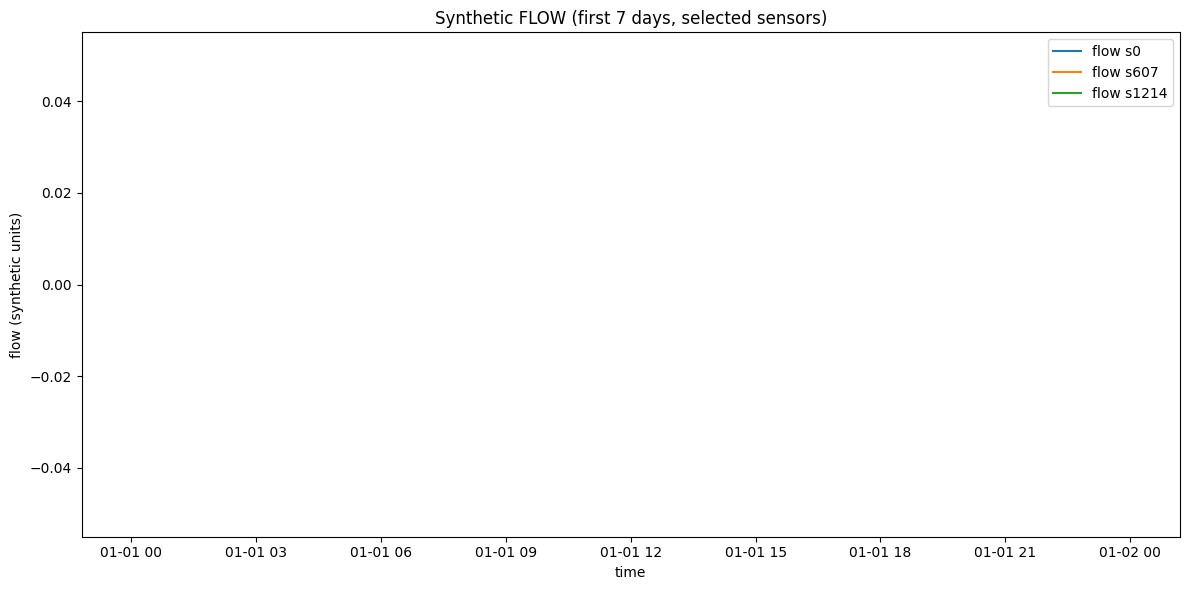

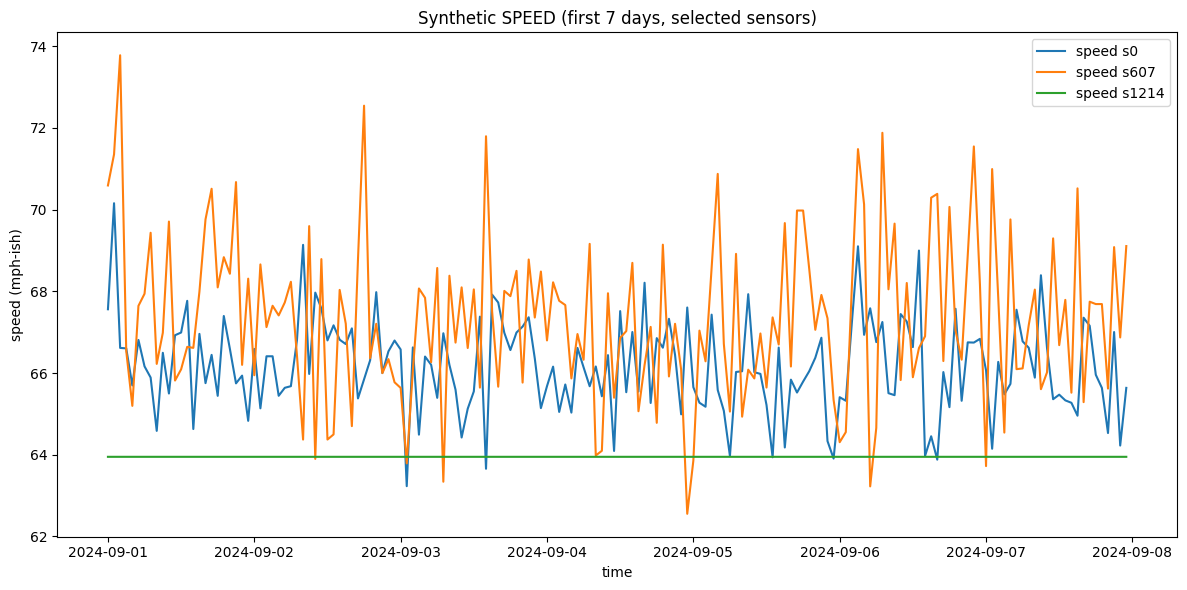

Saved figures: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/synthetic_pems_output/figures/diag_flow_timeseries_week1.png /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/synthetic_pems_output/figures/diag_speed_timeseries_week1.png


In [17]:
# Plot: example sensors (flow & speed) + save to figures/
# X currently loaded is imputed + (optional) moment matched

T, N, F = X.shape
dt = pd.to_datetime(d["timestamps"])
sensor_ids = [0, N//3, 2*N//3]

plt.figure(figsize=(12, 6))
for s in sensor_ids:
    plt.plot(dt[:7*24], X[:7*24, s, 0], label=f"flow s{s}")
plt.title("Synthetic FLOW (first 7 days, selected sensors)")
plt.xlabel("time")
plt.ylabel("flow (synthetic units)")
plt.legend()
plt.tight_layout()
flow_fig_path = FIGURES_DIR / "diag_flow_timeseries_week1.png"
plt.savefig(flow_fig_path, dpi=200)
plt.show()

plt.figure(figsize=(12, 6))
for s in sensor_ids:
    plt.plot(dt[:7*24], X[:7*24, s, 1], label=f"speed s{s}")
plt.title("Synthetic SPEED (first 7 days, selected sensors)")
plt.xlabel("time")
plt.ylabel("speed (mph-ish)")
plt.legend()
plt.tight_layout()
speed_fig_path = FIGURES_DIR / "diag_speed_timeseries_week1.png"
plt.savefig(speed_fig_path, dpi=200)
plt.show()

print("Saved figures:", flow_fig_path, speed_fig_path)

/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

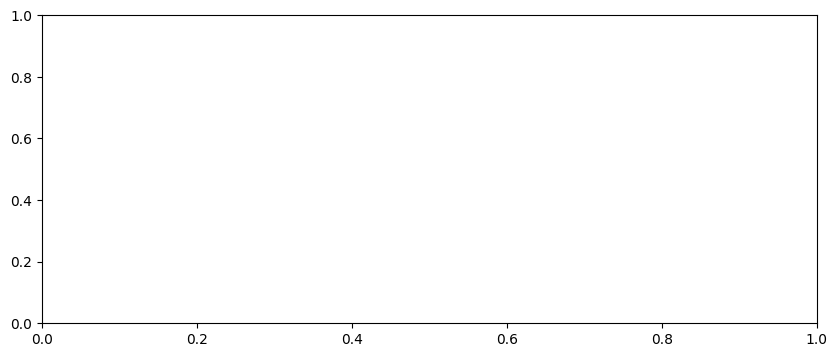

In [18]:
# Plot: distribution of flow and speed (random subsample to keep plot light)

rng = np.random.default_rng(0)
idx_t = rng.integers(0, T, size=20000)
idx_n = rng.integers(0, N, size=20000)

flow_samples = X[idx_t, idx_n, 0]
speed_samples = X[idx_t, idx_n, 1]

plt.figure(figsize=(10, 4))
plt.hist(flow_samples, bins=80)
plt.title("Synthetic flow distribution (random samples)")
plt.xlabel("flow")
plt.ylabel("count")
plt.tight_layout()
hist_flow_path = FIGURES_DIR / "diag_flow_hist.png"
plt.savefig(hist_flow_path, dpi=200)
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(speed_samples, bins=80)
plt.title("Synthetic speed distribution (random samples)")
plt.xlabel("speed")
plt.ylabel("count")
plt.tight_layout()
hist_speed_path = FIGURES_DIR / "diag_speed_hist.png"
plt.savefig(hist_speed_path, dpi=200)
plt.show()

print("Saved figures:", hist_flow_path, hist_speed_path)

## 10) Generate the full benchmark suite (all scenarios × seeds)

For a publication-grade synthetic benchmark, we recommend:
- at least **5 scenarios**
- at least **10 seeds** per scenario (mean ± std)

The loop below generates all dataset artifacts and writes a `manifest.csv` with summary stats.

In [19]:
SEEDS = list(range(10))  # publication standard: 10 seeds

manifest_rows = []

for scen in SCENARIOS.keys():
    for seed in SEEDS:
        path = generate_and_save_dataset(scen, seed=seed, moment_match=True)

        d = np.load(path, allow_pickle=True)
        X = d["X"]
        dt = pd.to_datetime(d["timestamps"])
        row = dict(
            scenario=scen,
            seed=int(d["seed"][0]) if "seed" in d else seed,
            path=str(path),
            T=int(X.shape[0]),
            N=int(X.shape[1]),
            F=int(X.shape[2]),
            train_windows=int(len(d["train_starts"])),
            val_windows=int(len(d["val_starts"])),
            test_windows=int(len(d["test_starts"])),
            start=str(dt[0]),
            end=str(dt[-1]),
        )
        manifest_rows.append(row)

manifest_df = pd.DataFrame(manifest_rows)
manifest_path = OUT_ROOT / "manifest.csv"
manifest_df.to_csv(manifest_path, index=False)

print("Wrote:", manifest_path)
manifest_df.head()

/tmp/ipykernel_42/1731245249.py:112: RuntimeWarning: overflow encountered in add
  z[t] = regime[t] * (ar + sp + s_node[t] + u[t] + eps)
/tmp/ipykernel_42/1731245249.py:115: RuntimeWarning: overflow encountered in multiply
  flow = np.log1p(np.exp(c[None, :] * z)).astype(np.float32)
/tmp/ipykernel_42/1731245249.py:115: RuntimeWarning: overflow encountered in exp
  flow = np.log1p(np.exp(c[None, :] * z)).astype(np.float32)
/usr/local/lib/python3.11/dist-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/tmp/ipykernel_42/1731245249.py:43: RuntimeWarning: invalid value encountered in subtract
  out = (arr - mu[None, :]) / sd[None, :] * target_std[None, :] + target_mean[None, :]
/tmp/ipykernel_42/1731245249.py:112: RuntimeWarning: overflow encountered in add
  z[t] = regime[t] * (ar + sp + s_node[t] + u[t] + eps)
/tmp/ipykernel_42/1731245249.py:115: RuntimeWarning: overflow encounte

Wrote: /notebooks/Spatio-Temporal-Prediction-and-Coordination-of-EV-Charging-Demand-for-Power-System-Resilience/synthetic_pems_output/manifest.csv


,scenario,seed,path,T,N,F,train_windows,val_windows,test_windows,start,end
0,A_nominal,0,/notebooks/Spatio-Temporal-Prediction-and-Coor...,2928,1821,6,1729,289,673,2024-09-01 00:00:00,2024-12-31 23:00:00
1,A_nominal,1,/notebooks/Spatio-Temporal-Prediction-and-Coor...,2928,1821,6,1729,289,673,2024-09-01 00:00:00,2024-12-31 23:00:00
2,A_nominal,2,/notebooks/Spatio-Temporal-Prediction-and-Coor...,2928,1821,6,1729,289,673,2024-09-01 00:00:00,2024-12-31 23:00:00
3,A_nominal,3,/notebooks/Spatio-Temporal-Prediction-and-Coor...,2928,1821,6,1729,289,673,2024-09-01 00:00:00,2024-12-31 23:00:00
4,A_nominal,4,/notebooks/Spatio-Temporal-Prediction-and-Coor...,2928,1821,6,1729,289,673,2024-09-01 00:00:00,2024-12-31 23:00:00




> **Synthetic benchmark.** To validate robustness under controlled conditions, we construct a synthetic spatio-temporal dataset with the same tensor format as PeMS. The input tensor is $X\in\mathbb{R}^{T\times N\times F}$ and targets are $Y\in\mathbb{R}^{T\times N}$, with $F=6$ consisting of flow, speed, and sinusoidal hour/day-of-week encodings. We simulate latent traffic states with a graph-coupled autoregressive process that incorporates diurnal and weekly periodicity, incident shocks, and heteroskedastic noise. Missingness is injected using random point drops and block outages, and imputed using a leakage-safe procedure based on forward-fill and train-only statistics. We enforce strict horizon containment when splitting train/validation/test windows to prevent any label leakage.